In [1]:
from MGRG.Graph import Graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
estifings = np.load('data/estimated-fingerprints100.npy')
estifings /= np.tile(np.linalg.norm(estifings,axis=1).reshape(4096,1),(1,9))
params = np.load('data/params100.npy') 
estiparams = np.load('data/estimated-params100.npy') 

In [4]:
A = np.zeros((1000,1000))

for i in range(1000):
    for j in range(1000):
        A[i,j] = 1
        if np.abs(params[i,1]-params[j,1])>0.01:
            A[i,j] = 0

G = Graph(1000, 9, adjacency_matrix = A)

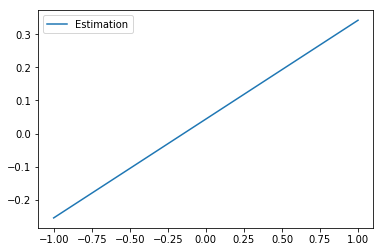

In [5]:
G.HAC_R_study()
G.plot_estimation_enveloppe(True_envelope=False)

In [ ]:
A = np.zeros((1000,1000))

for i in range(1000):
    for j in range(1000):
        A[i,j] = 1
        if np.abs(estiparams[i,1]-estiparams[j,1])>0.1:
            A[i,j] = 0

G = Graph(1000, 9, adjacency_matrix = A, vectors = estifings[:1000,:].T)

In [ ]:
np.sum(A)/1000**2

In [ ]:
G.HAC_R_study()
G.plot_estimation_enveloppe(True_envelope=False)

In [3]:
def study_error(latitude,enveloppe):
    d = 3
    results  = {'error_enveloppe':[],'error_latitude':[],'size':[]}
    listen = list(map(int,np.logspace(np.log10(20),2,2)))
    for n in listen:
        for _ in range(2):
            G = Graph(n, d, sampling_type = 'markov', latitude = latitude, enveloppe = enveloppe)
            G.HAC_R_study()
            results['error_enveloppe'].append(G.error_estimation_enveloppe())
            results['error_latitude'].append(G.error_estimation_latitude())
            results['size'].append(n)
    df = pd.DataFrame(results)
    df = df.apply(np.log10)
    return df

import seaborn as sns
def plot_errors(dataframe):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121)
    sns.lineplot(x="size", y="error_enveloppe", err_style="bars", data=dataframe, ax = ax)
    #dataframe.plot(ax=ax, kind='scatter',x='size',y='error_enveloppe',color='red')
    ax.set_xlabel('$\log \;n$', fontsize=16)
    ax.set_ylabel('$\log \;\delta_2(p^*,\hat{p})$', fontsize=16)
    ax.set_title('Estimation Error Envelope function', fontsize=16)
    ax = fig.add_subplot(122)
    sns.lineplot(x="size", y="error_latitude", err_style="bars", data=dataframe, ax = ax)
    #dataframe.plot(ax=ax , kind='scatter',x='size',y='error_latitude',color='red')
    ax.set_xlabel('$\log \; n$', fontsize=16)
    ax.set_ylabel('$\log \; \delta_2(f^*,\hat{f})$', fontsize=16)
    ax.set_title('Estimation Error Latitude function', fontsize=16)
#     ax = fig.add_subplot(12)
#     sns.lineplot(x="size", y="error_gram", err_style="bars", data=dataframe, ax = ax)
#     #dataframe.plot(ax=ax , kind='scatter',x='size',y='error_latitude',color='red')
#     ax.set_xlabel('$\log \;n$', fontsize=16)
#     ax.set_ylabel('$\log  \;\|\| G-\hat{G} \|\|_F$', fontsize=16)
#     ax.set_title('Error Gram matrix', fontsize=16)
    plt.savefig('')
    plt.show()

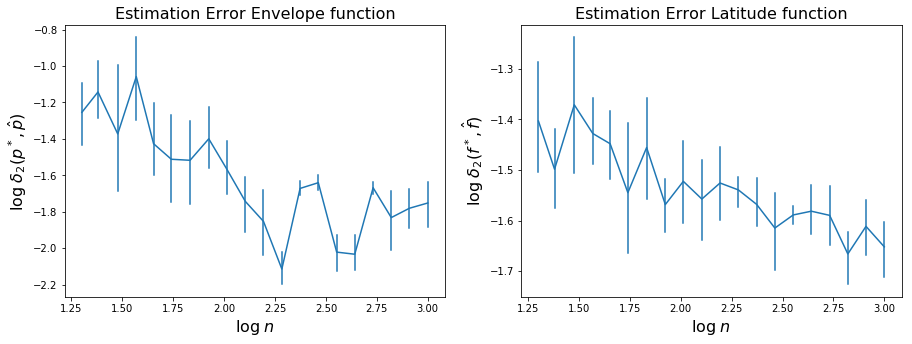

In [89]:
df = np.load('data/testdf-linear-prim1_heaviside.pkl')
df['error_gram'] =np.log10( (10**df['error_gram'])/ (10**df['size']))
plot_errors(df)

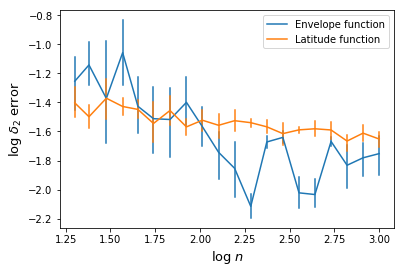

In [5]:
df = np.load('data/testdf-linear-prim1_heaviside.pkl')
sns.lineplot(x="size", y="error_enveloppe", err_style="bars", data=df, label='Envelope function')
sns.lineplot(x="size", y="error_latitude", err_style="bars", data=df, label='Latitude function',linestyle='dashed')
plt.xlabel('$\log \;n$', fontsize=13)
plt.ylabel('$\log \;\delta_2$ error', fontsize=13)
#plt.title('Estimation Error Envelope function', fontsize=16)
plt.savefig('err_lin-p1heavi.png',dpi=300)

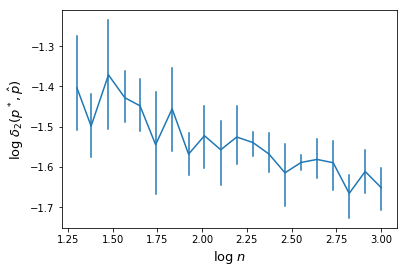

In [91]:
sns.lineplot(x="size", y="error_latitude", err_style="bars", data=df)
plt.xlabel('$\log \;n$', fontsize=13)
plt.ylabel('$\log \;\delta_2(p^*,\hat{p})$', fontsize=13)
#plt.title('Estimation Error Envelope function', fontsize=16)
plt.savefig('err_lat_lin-p1heavi.png',dpi=300)

In [ ]:
n = 400
d = 3
np.random.seed(4)
G = Graph(n, d, 'markov', latitude='default', enveloppe='sinus')
G.HAC_R_study(figure=True)

In [ ]:
n = 800
d = 3
np.random.seed(4)
G = Graph(n, d, 'markov', latitude='mixture', enveloppe='prim1_heaviside')
G.HAC_R_study()
G.plot_estimation_enveloppe()